In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
print("Debut du programme")
spark = SparkSession.builder \
    .appName("Lecture CSV avec PySpark") \
    .getOrCreate()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark with Hadoop Native Libraries") \
    .config("spark.driver.extraLibraryPath", "/usr/local/hadoop/lib/native") \
    .config("spark.executor.extraLibraryPath", "/usr/local/hadoop/lib/native") \
    .getOrCreate()
#////////////////////////////
print("Session Spark creée correctement")
df = spark.read.csv('hdfs://localhost:9000/user/hadoop/testput.csv', header=True, inferSchema=True, sep=";")
#df = spark.read.csv('df.csv', header=True, inferSchema=True, sep=";")

print("Fichier lu correctement")
nombre_fraudes = df.filter(df["is_fraud"] == 1)
print("Nombre de transactions frauduleuses :", nombre_fraudes.count())


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x39tvly6 because the default path (/home/a7medrd99/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Debut du programme


23/07/14 14:28:57 WARN Utils: Your hostname, penguin resolves to a loopback address: 127.0.1.1; using 100.115.92.195 instead (on interface eth0)
23/07/14 14:28:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/14 14:29:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/14 14:29:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Session Spark creée correctement


Fichier lu correctement


Nombre de transactions frauduleuses : 2145


In [2]:
print("Nombre de transactions normales :", df.count() - nombre_fraudes.count())
total_fraud_amount = df.filter(df["is_fraud"] == 1).agg({"amt": "sum"}).collect()[0][0]
#avoid collect
print("Total amount of fraudulent transactions:", total_fraud_amount)
commercant_plus_frequent = df.filter(df["is_fraud"] == 1).groupBy("merchant").count().orderBy("count", ascending=False).first()[0]
print("Commerçant le plus fréquent dans les transactions frauduleuses :", commercant_plus_frequent)
transactions_fraudes_par_categorie = df.filter(df["is_fraud"] == 1).groupBy("category").count().orderBy("count", ascending=False)
transactions_fraudes_par_categorie.show()
clients_selectionnes = ["Williams", "Massey", "Evans"]
profil_clients = df.filter(df["last"].isin(clients_selectionnes))
profil_clients = profil_clients.withColumn("amt", col("amt").cast("float"))
transactions_par_client = profil_clients.groupBy("last").count()
montant_total_par_client = profil_clients.groupBy("last").sum("amt")
categories_frequentes_par_client = profil_clients.groupBy("last", "category").count().orderBy("count", ascending=False)
montant_moyen_par_client = profil_clients.groupBy("last").avg("amt")
dates_premiere_derniere_transaction = profil_clients.groupBy("last").agg({"trans_date_trans_time": "min","trans_date_trans_time": "max"})
transactions_par_client.show()
montant_total_par_client.show()
categories_frequentes_par_client.show()
montant_moyen_par_client.show()
dates_premiere_derniere_transaction.show()


Nombre de transactions normales : 553574


Total amount of fraudulent transactions: 1133324.6799999992


Commerçant le plus fréquent dans les transactions frauduleuses : fraud_Lemke-Gutmann


+--------------+-----+
|      category|count|
+--------------+-----+
|  shopping_net|  506|
|   grocery_pos|  485|
|      misc_net|  267|
|  shopping_pos|  213|
| gas_transport|  154|
|      misc_pos|   72|
| personal_care|   70|
|          home|   67|
|     kids_pets|   65|
| entertainment|   59|
|   food_dining|   54|
|health_fitness|   52|
|   grocery_net|   41|
|        travel|   40|
+--------------+-----+



+--------+-----+
|    last|count|
+--------+-----+
|Williams|10056|
|   Evans| 2155|
|  Massey| 1095|
+--------+-----+



+--------+-----------------+
|    last|         sum(amt)|
+--------+-----------------+
|Williams|668850.2302863598|
|   Evans|132417.5397799015|
|  Massey|61691.58009958267|
+--------+-----------------+



+--------+--------------+-----+
|    last|      category|count|
+--------+--------------+-----+
|Williams| gas_transport| 1125|
|Williams|          home|  941|
|Williams|  shopping_pos|  907|
|Williams|   grocery_pos|  893|
|Williams|     kids_pets|  876|
|Williams| personal_care|  768|
|Williams| entertainment|  724|
|Williams|  shopping_net|  705|
|Williams|   food_dining|  690|
|Williams|health_fitness|  638|
|Williams|      misc_pos|  580|
|Williams|      misc_net|  493|
|Williams|   grocery_net|  390|
|Williams|        travel|  326|
|   Evans| gas_transport|  259|
|   Evans|          home|  213|
|   Evans|  shopping_pos|  201|
|   Evans|   grocery_pos|  190|
|   Evans|     kids_pets|  182|
|   Evans|  shopping_net|  161|
+--------+--------------+-----+
only showing top 20 rows



+--------+------------------+
|    last|          avg(amt)|
+--------+------------------+
|Williams| 66.51255273332933|
|   Evans|61.446654190209514|
|  Massey|  56.3393425566965|
+--------+------------------+



+--------+--------------------------+
|    last|max(trans_date_trans_time)|
+--------+--------------------------+
|   Evans|          31/12/2020 23:17|
|  Massey|          31/12/2020 21:34|
|Williams|          31/12/2020 23:58|
+--------+--------------------------+



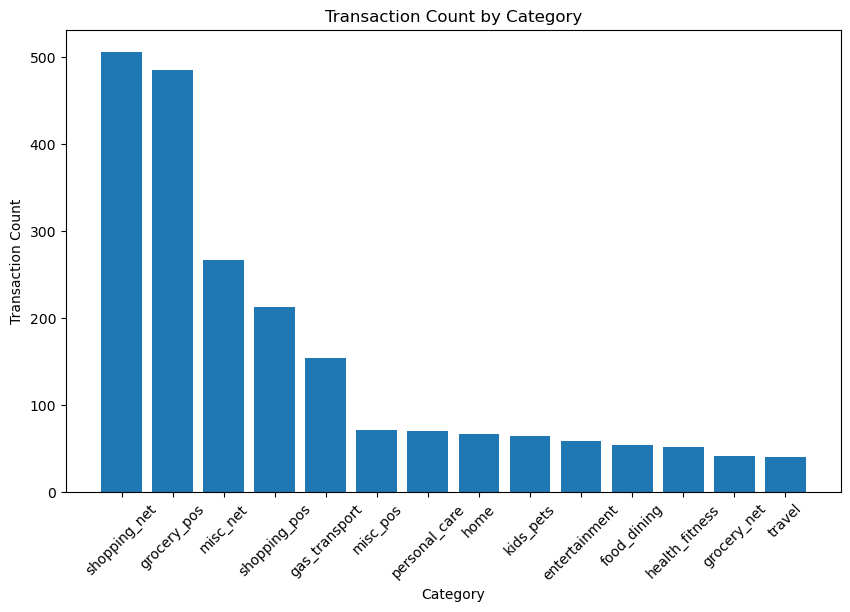

In [3]:
category_counts = transactions_fraudes_par_categorie.toDF("category", "count")
category_counts = category_counts.withColumn("count", category_counts["count"].cast("int"))
category_series = category_counts.select("category", "count").rdd.map(lambda x: (x[0], x[1])).collect()
categories = [x[0] for x in category_series]
counts = [x[1] for x in category_series]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(categories, counts)
ax.set_xlabel('Category')
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Count by Category')
ax.tick_params(axis='x', rotation=45)
plt.show()

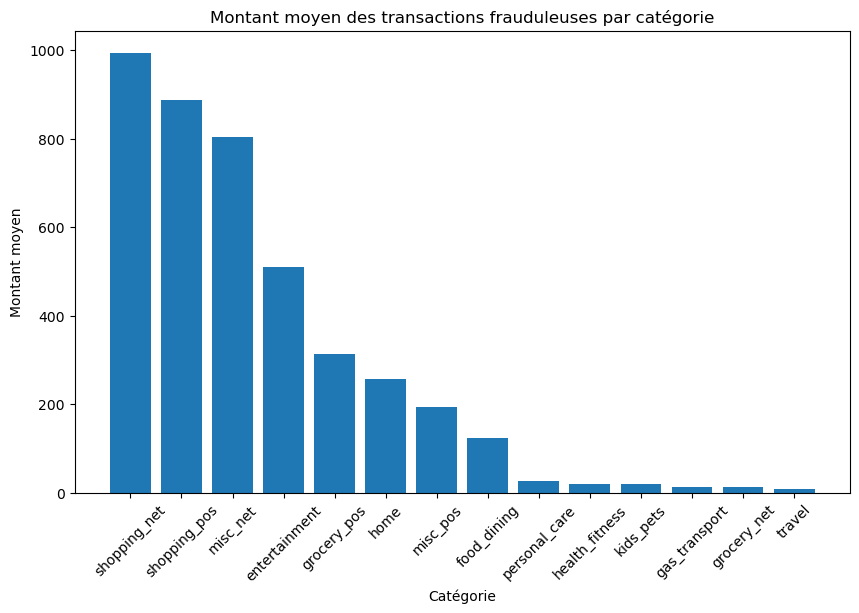

In [4]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
montant_moyen_fraudes_par_categorie = df.filter(df["is_fraud"] == 1).groupBy("category").agg(F.avg("amt").alias("avg_amt")).orderBy("avg_amt", ascending=False)
stat_data = montant_moyen_fraudes_par_categorie.collect()
categories = [row["category"] for row in stat_data]
avg_amounts = [row["avg_amt"] for row in stat_data]
plt.figure(figsize=(10, 6))
plt.bar(categories, avg_amounts)
plt.xlabel("Catégorie")
plt.ylabel("Montant moyen")
plt.title("Montant moyen des transactions frauduleuses par catégorie")
plt.xticks(rotation=45)
plt.show()


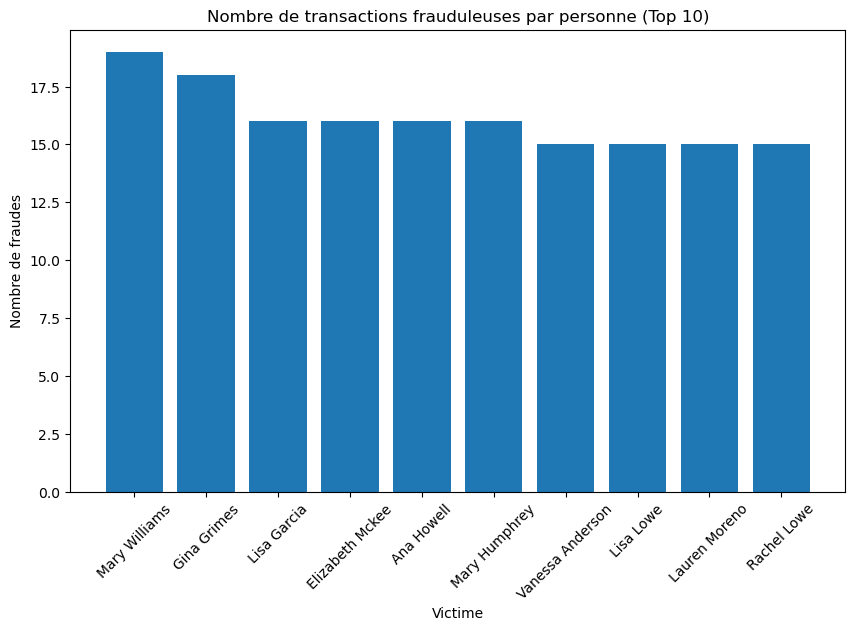

In [6]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

top_n = 10
victimes_fraudes = df.filter(df["is_fraud"] == 1).groupBy("first", "last").count().orderBy("count", ascending=False).limit(top_n)

stat_data = victimes_fraudes.collect()
victimes = ["{} {}".format(row["first"], row["last"]) for row in stat_data]
nombre_fraudes = [round(row["count"]) for row in stat_data]  # Arrondir à l'entier le plus proche

plt.figure(figsize=(10, 6))
plt.bar(victimes, nombre_fraudes)
plt.xlabel("Victime")
plt.ylabel("Nombre de fraudes")
plt.title("Nombre de transactions frauduleuses par personne (Top {})".format(top_n))
plt.xticks(rotation=45)
plt.show()


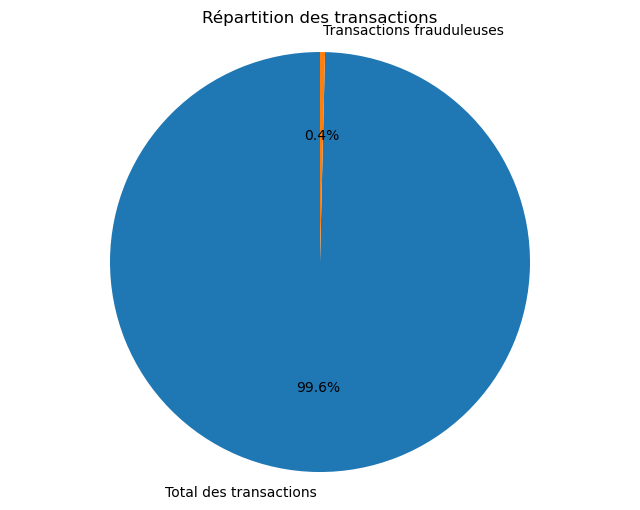

In [7]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nombre_transactions_total = df.count()
nombre_transactions_fraudes = df.filter(df["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Répartition des transactions")
plt.show()


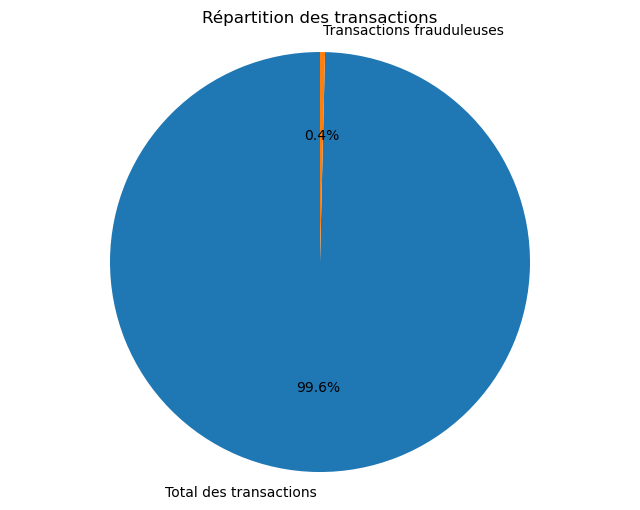

In [8]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nombre_transactions_total = df.count()
nombre_transactions_fraudes = df.filter(df["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Répartition des transactions")
plt.show()


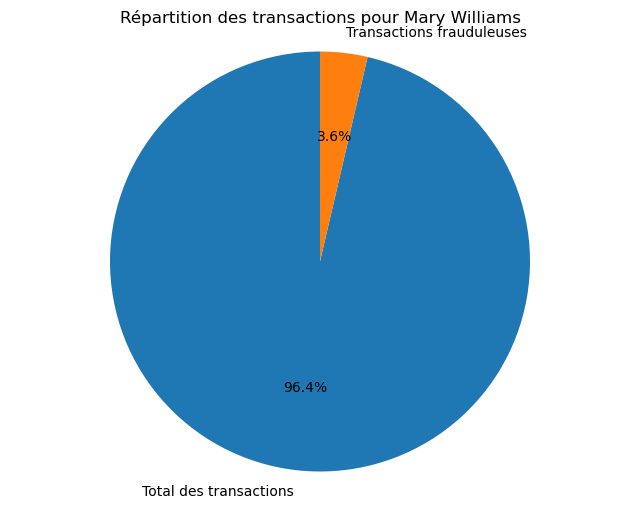

In [9]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nom = "Williams"
prenom = "Mary"

transactions_personne = df.filter((df["last"] == nom) & (df["first"] == prenom))
nombre_transactions_total = transactions_personne.count()
nombre_transactions_fraudes = transactions_personne.filter(transactions_personne["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Répartition des transactions pour {} {}".format(prenom, nom))
plt.show()


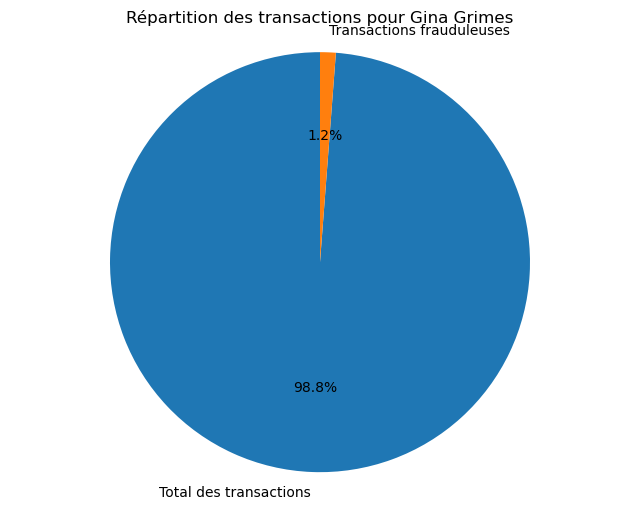

In [10]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nom = "Grimes"
prenom = "Gina"

transactions_personne = df.filter((df["last"] == nom) & (df["first"] == prenom))
nombre_transactions_total = transactions_personne.count()
nombre_transactions_fraudes = transactions_personne.filter(transactions_personne["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Répartition des transactions pour {} {}".format(prenom, nom))
plt.show()


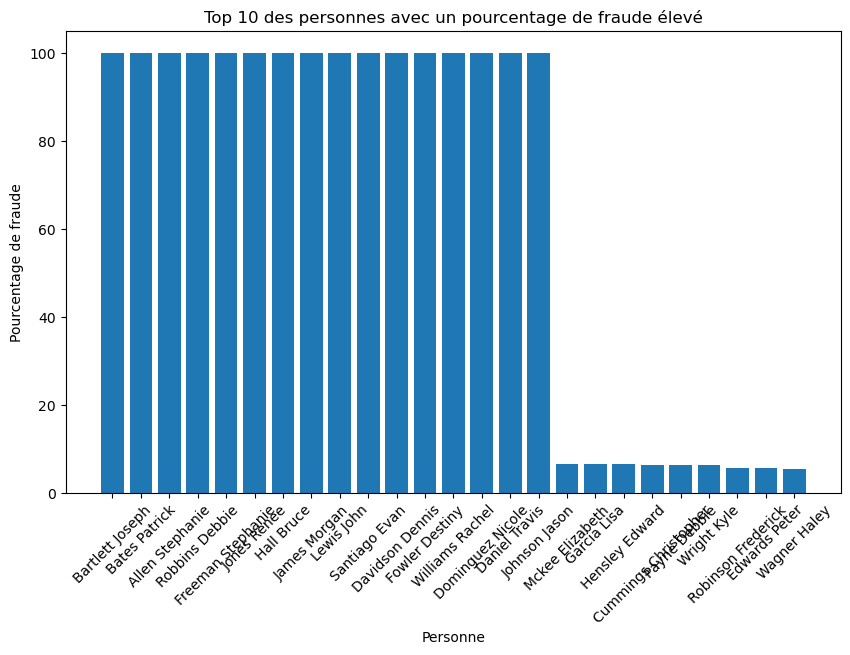

In [11]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

pourcentage_fraude_par_personne = df.groupBy("last", "first").agg(
    (F.sum(F.col("is_fraud")) / F.count("*") * 100).alias("pourcentage_fraude")
)

top_10_personnes_fraude = pourcentage_fraude_par_personne.orderBy(F.desc("pourcentage_fraude")).limit(25)

personnes = top_10_personnes_fraude.select(F.concat(F.col("last"), F.lit(" "), F.col("first")).alias("personne")).collect()
pourcentages_fraude = top_10_personnes_fraude.select("pourcentage_fraude").collect()

personnes = [row["personne"] for row in personnes]
pourcentages_fraude = [row["pourcentage_fraude"] for row in pourcentages_fraude]

plt.figure(figsize=(10, 6))
plt.bar(personnes, pourcentages_fraude)
plt.xlabel("Personne")
plt.ylabel("Pourcentage de fraude")
plt.title("Top 10 des personnes avec un pourcentage de fraude élevé")
plt.xticks(rotation=45)
plt.show()


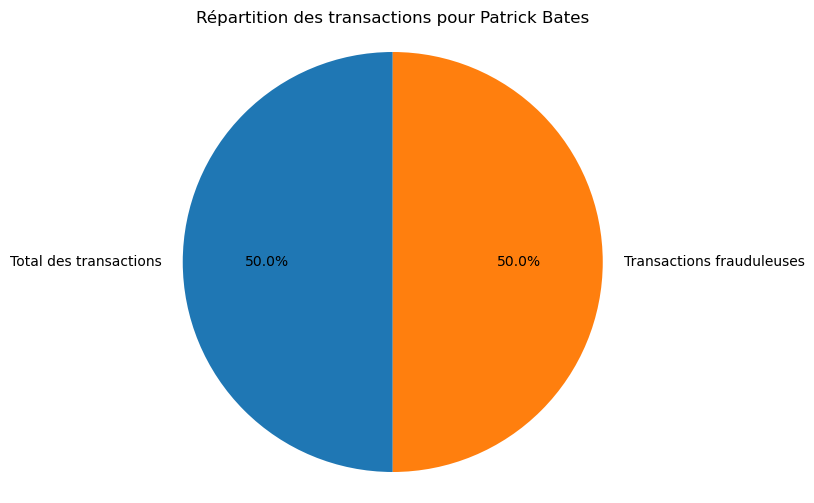

In [12]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nom = "Bates"
prenom = "Patrick"

transactions_personne = df.filter((df["last"] == nom) & (df["first"] == prenom))
nombre_transactions_total = transactions_personne.count()
nombre_transactions_fraudes = transactions_personne.filter(transactions_personne["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Répartition des transactions pour {} {}".format(prenom, nom))
plt.show()


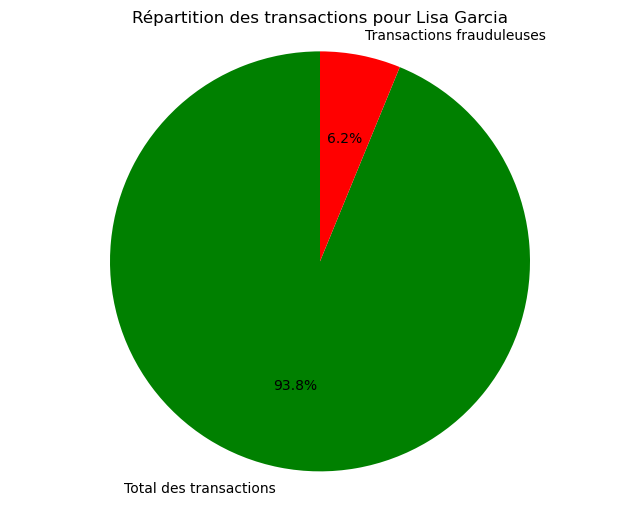

In [15]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

nom = "Garcia"
prenom = "Lisa"

transactions_personne = df.filter((df["last"] == nom) & (df["first"] == prenom))
nombre_transactions_total = transactions_personne.count()
nombre_transactions_fraudes = transactions_personne.filter(transactions_personne["is_fraud"] == 1).count()

labels = ["Total des transactions", "Transactions frauduleuses"]
sizes = [nombre_transactions_total, nombre_transactions_fraudes]
colors = ['green', 'red']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title("Répartition des transactions pour {} {}".format(prenom, nom))
plt.show()
